# 0. Imports

In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

import pandas as pd
import numpy as np
from utils import set_seeds, load_datasets
from preprocessing import fundamental_preprocessing
import torch
from text_enrichment import *

# Plotting utils
import matplotlib.pyplot as plt
from plot import wordcloud, labels_hist, sentence_lenght, plot_number_of_characters, plot_average_word_length, plot_most_frequent_words
import seaborn as sns

%load_ext autoreload
%autoreload 2

Importato package text_enrichment.


/home/francesco/Desktop/review_codice/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Inspection

## 1. Corpus

In [32]:
train_set, val_set, test_set = load_datasets(parent_dir + "/data")

train_set.columns = ['drop']+list(train_set.columns[1:])
val_set.columns = ['drop']+list(val_set.columns[1:])
test_set.columns = ['drop']+list(test_set.columns[1:])

train_set.drop('drop', inplace=True, axis=1)
val_set.drop('drop', inplace=True, axis=1)
test_set.drop('drop', inplace=True, axis=1)

In [4]:
train_set.head()

,iro,text
0,0,Intanto la partita per Via Nazionale si compli...
1,0,"False illusioni, sgradevoli realtà Mario Monti..."
2,0,"False illusioni, sgradevoli realtà #editoriale..."
3,0,Mario Monti: Berlusconi risparmi all'Italia il...
4,0,Mario Monti: Berlusconi risparmi all'Italia il...


In [5]:
for tweet in train_set['text'].iloc[:10]:
    print(tweet)

Intanto la partita per Via Nazionale si complica. #Saccomanni dice che "mica tutti sono Mario #Monti" http://t.co/xPtNz4X7 via @linkiesta
False illusioni, sgradevoli realtà Mario Monti http://t.co/WOmMCITs via @AddToAny
False illusioni, sgradevoli realtà #editoriale di Mario Monti sul Corriere della Sera: http://t.co/2jPxX6Jm #rassegna stampa
Mario Monti: Berlusconi risparmi all'Italia il biasimo per aver causato un disastro #mariomontipremier
Mario Monti: Berlusconi risparmi all'Italia il biasimo per aver causato un disastro. I giudizi di Usa e Europa. http://t.co/evXRFF1L
False illusioni, sgradevoli realtà Analisi impeccabile di Mario Monti, e l'ennesimo grido di allarme http://t.co/T5GTgIeE via @AddThis
L'attacco di Mario Monti al governo Berlusconi -False illusioni, sgradevoli realtà Corriere della Sera: http://t.co/h9X8OeQS
Mario Monti sul Corriere: la fotografia più illuminante sulla delicata situazione attuale http://t.co/YbuNZMOJ
Le 5 sgradevoli realtà di cui Berlusconi dovrebb

### 1.1 Checking for duplicates

In [6]:
duplicated_rows = train_set.duplicated(subset=["text"])

In [7]:
print(duplicated_rows.sum())

8


In [8]:
print(train_set[duplicated_rows])

      iro                                               text
1983    0                                        mario monti
2082    0  Per quanto riguarda il Governo Monti considera...
2091    0  New comment: Mario Monti: torna l'Ici. Riforma...
3869    0  #Grillo potrebbe far del male a questo paese, ...
4449    0  TT Twitter Italia 05:30: 1.#cinemaInChiesa 2.#...
4615    0  L'Italia sono anch'io. Perciò scelgo #Grillo #...
4637    0      Anche allo stadio si canta #Grillo uno di noi
5841    0  Ciao @rtl1025official. vorrei sentire una canz...


In [9]:
train_set.drop_duplicates(subset=["text"], inplace=True, ignore_index=True)

### 1.2 Checking for missing values

In [10]:
missing_values = train_set.isnull().sum()
print(missing_values)

iro     0
text    0
dtype: int64


In [11]:
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(7402, 2)
(1000, 2)
(1000, 2)


In [12]:
train_set

,iro,text
0,0,Intanto la partita per Via Nazionale si compli...
1,0,"False illusioni, sgradevoli realtà Mario Monti..."
2,0,"False illusioni, sgradevoli realtà #editoriale..."
3,0,Mario Monti: Berlusconi risparmi all'Italia il...
4,0,Mario Monti: Berlusconi risparmi all'Italia il...
...,...,...
7397,1,"che ci frega di mario monti, noi abbiamo mario..."
7398,1,Strepitoso il titolo in prima di Libero sul go...
7399,1,"@nataliacavalli Consolati, il governo #Monti h..."
7400,1,"@SheisCandida beh, beate loro! Io nn possiedo ..."


## 2. Data Distributions

In [13]:
train_set_split = train_set.copy(deep=True)
test_set_split = test_set.copy(deep=True)
val_set_split = val_set.copy(deep=True)

train_set_split['split'] = 'train'
test_set_split['split'] = 'test'
val_set_split['split'] = 'val'

df = pd.concat([train_set_split, val_set_split, test_set_split], axis=0)
df

,iro,text,split
0,0,Intanto la partita per Via Nazionale si compli...,train
1,0,"False illusioni, sgradevoli realtà Mario Monti...",train
2,0,"False illusioni, sgradevoli realtà #editoriale...",train
3,0,Mario Monti: Berlusconi risparmi all'Italia il...,train
4,0,Mario Monti: Berlusconi risparmi all'Italia il...,train
...,...,...,...
995,0,#nobel #labuonascuola #education Mentre ieri v...,test
996,0,"#iononcisto anche a #Mantova,contro #labuonasc...",test
997,0,"#labuonascuola una riforma distruttiva,nello s...",test
998,0,La buona scuola: ottima partenza ma quadro da ...,test


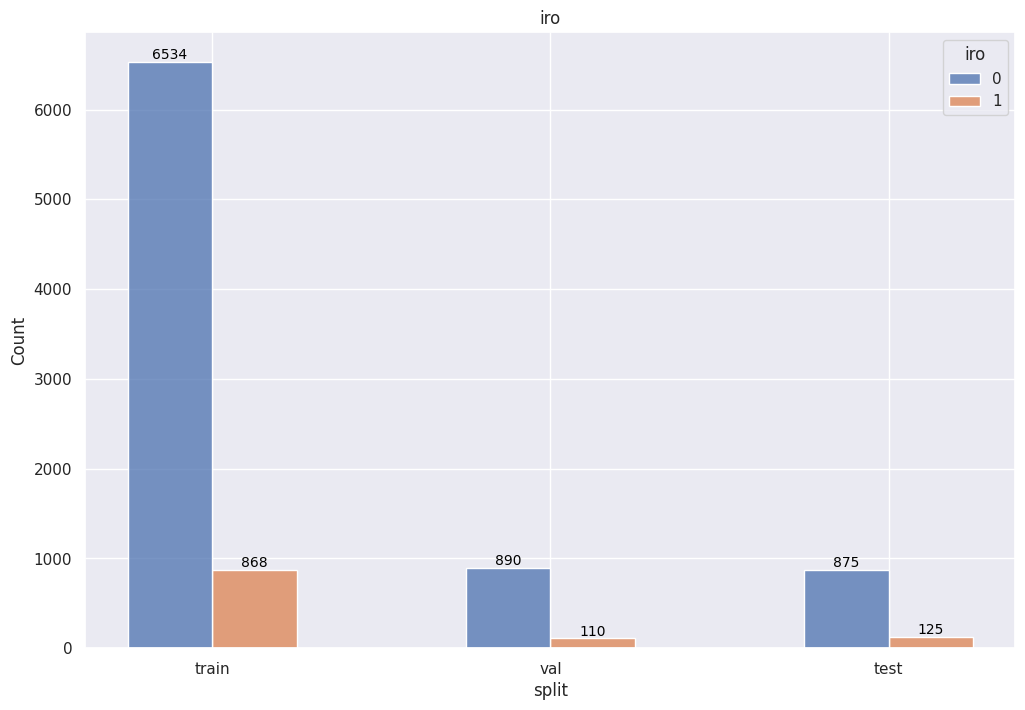

In [14]:
labels_hist(data=df)

The dataset is heavily unbalanced: the ironic tweets are far less than the non-ironic tweets ($\sim 13\%$).

In [15]:
outdir = os.path.join(parent_dir, "1_data_exploration", "output")
os.makedirs(outdir, exist_ok=True)

train_set.to_csv(outdir + "/train.csv", index=False)
val_set.to_csv(outdir + "/val.csv", index=False)
test_set.to_csv(outdir + "/test.csv", index=False)

### Preliminary (COSMETIC) preprocessing

Before visualizing some statistics about the length of the Tweets and the most frequent terms, we perform a preliminary preprocessing step to remove the noise that would otherwise disrupt our visualizations.  

In particular, we will: 
- lowercase the text
- remove urls
- remove video placeholders
- remove html entities
- remove retweet markers
- normalize whitespaces

In [16]:
from preprocessing import fundamental_preprocessing
from utils import load_datasets

train_set_for_visual = train_set.copy(deep=True)
val_set_for_visual = val_set.copy(deep=True)
test_set_for_visual = test_set.copy(deep=True)

for subset in (train_set_for_visual, val_set_for_visual, test_set_for_visual):
    fundamental_preprocessing(
        data=subset,
        lowercase=True,
        remove_urls=True,
        remove_video_placeholders=True,
        remove_html_entities=True,
        remove_retweet_markers=True,
        normalize_whitespace=True
    )

### Number of words per Tweet

### Full Train Set

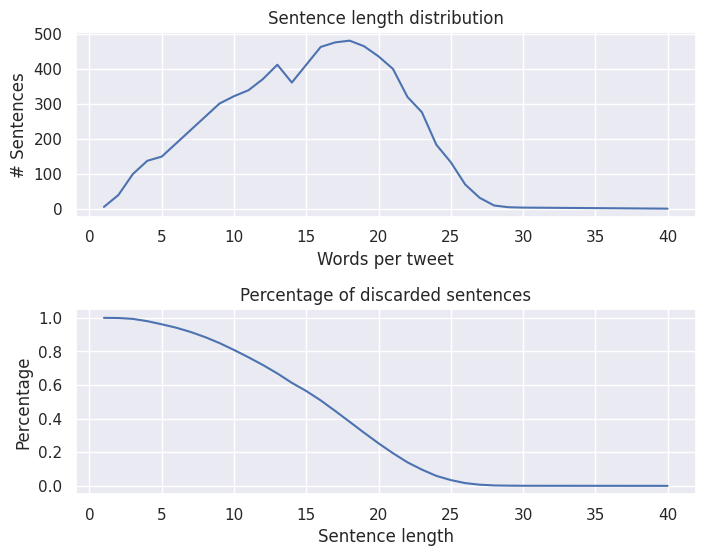

In [17]:
sentence_lenght(train_set_for_visual)

### Train Set - irony=0

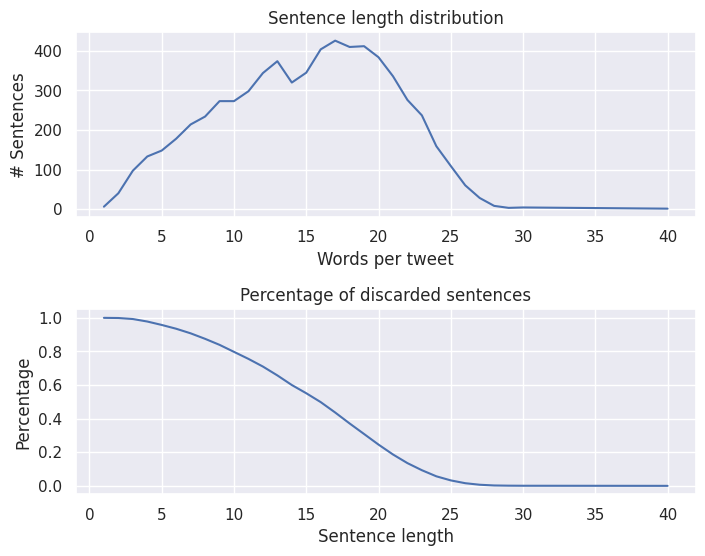

In [18]:
sentence_lenght(train_set_for_visual[ train_set_for_visual["iro"]==0 ])

### Train Set - irony=1

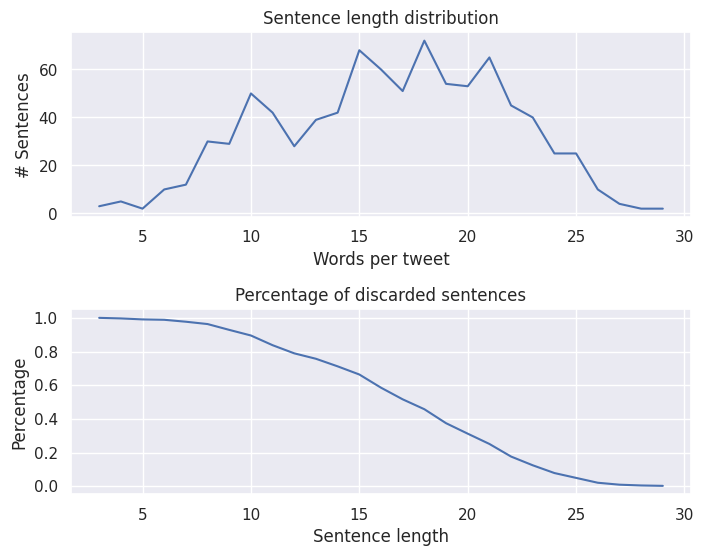

In [19]:
sentence_lenght(train_set_for_visual[ train_set_for_visual["iro"]==1 ])

### Number of characters per Tweet

In [20]:
train_set_for_visual['tweet_len'] = train_set_for_visual.text.apply(len)

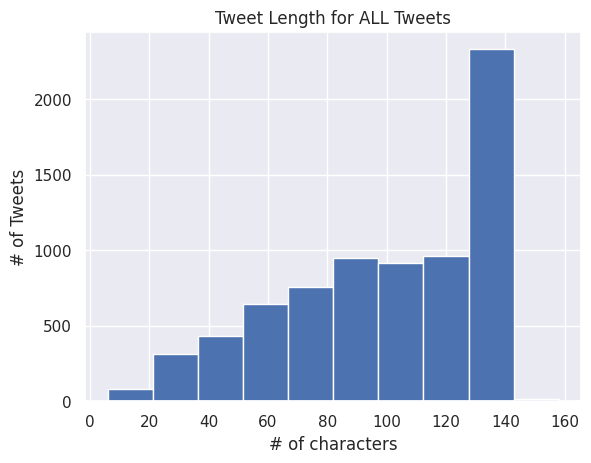

In [21]:
plot_number_of_characters(train_set_for_visual["text"])

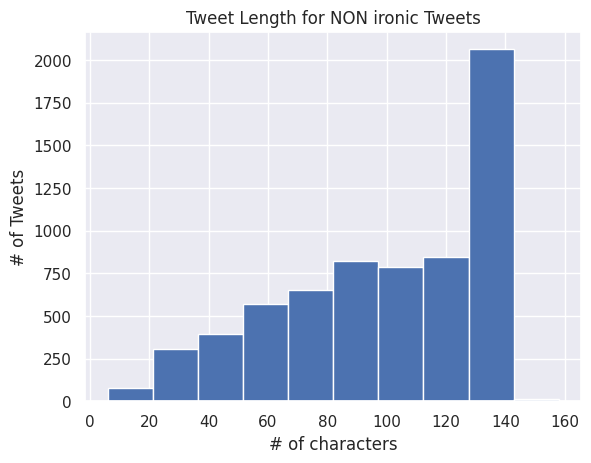

In [22]:
plot_number_of_characters(train_set_for_visual[train_set_for_visual["iro"] == 0]["text"], "NON ironic")

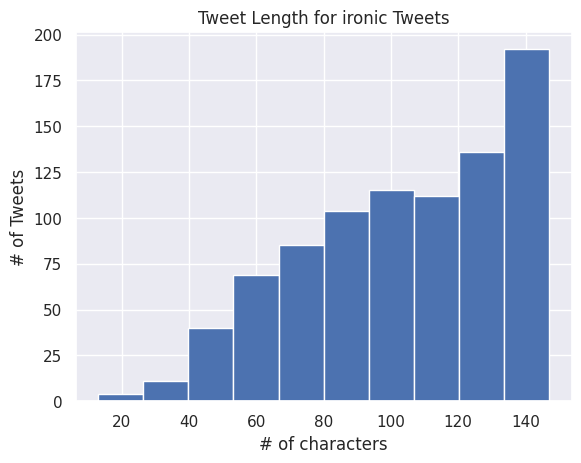

In [23]:
plot_number_of_characters(train_set_for_visual[train_set_for_visual["iro"] == 1]["text"], "ironic")

### Average word length per Tweet

44


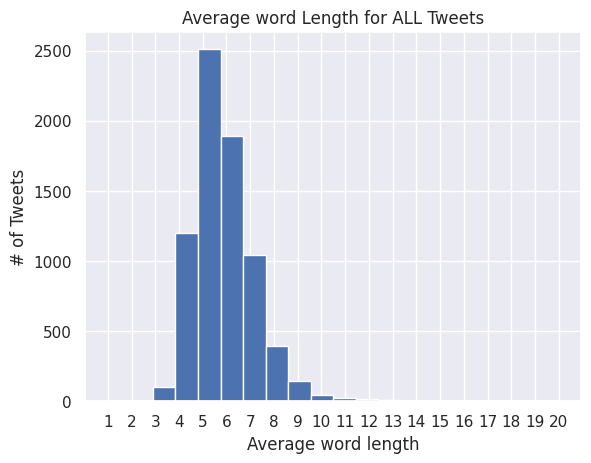

In [24]:
plot_average_word_length(train_set_for_visual["text"])

44


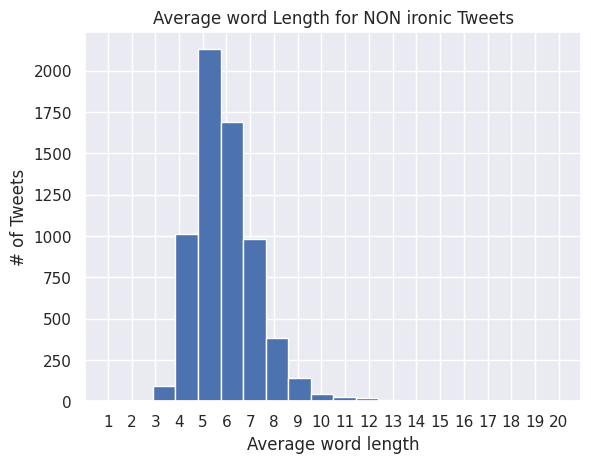

In [25]:
plot_average_word_length(train_set_for_visual[train_set_for_visual["iro"] == 0]["text"], "NON ironic")

10


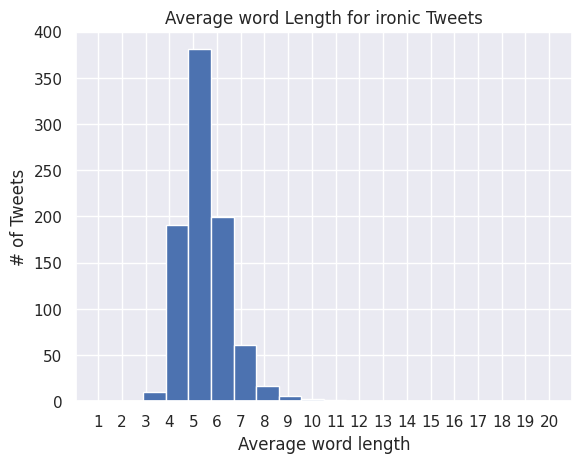

In [26]:
plot_average_word_length(train_set_for_visual[train_set_for_visual["iro"] == 1]["text"], "ironic")

### Most frequent words

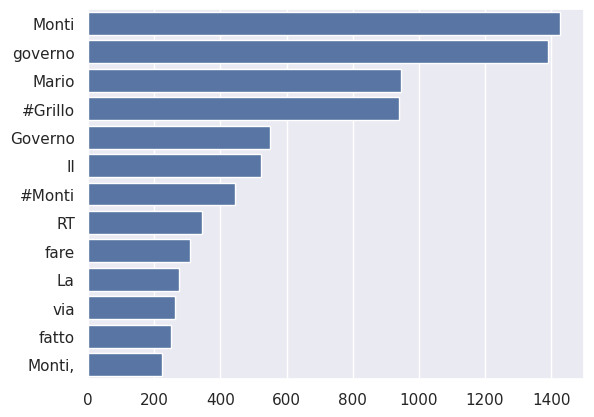

In [27]:
plot_most_frequent_words(train_set_for_visual["text"])

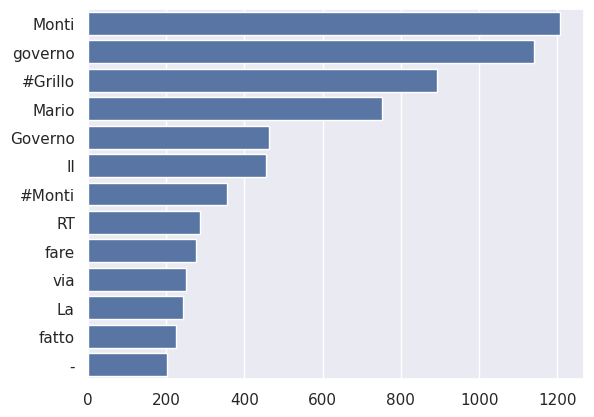

In [28]:
plot_most_frequent_words(train_set_for_visual[train_set_for_visual["iro"] == 0]["text"], "NON ironic")

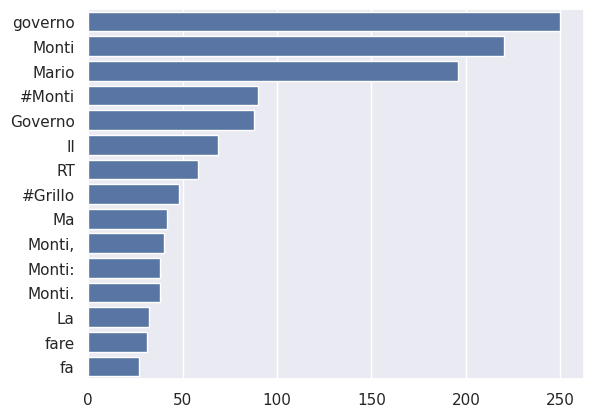

In [29]:
plot_most_frequent_words(train_set_for_visual[train_set_for_visual["iro"] == 1]["text"], "ironic")

OSError: cannot open resource

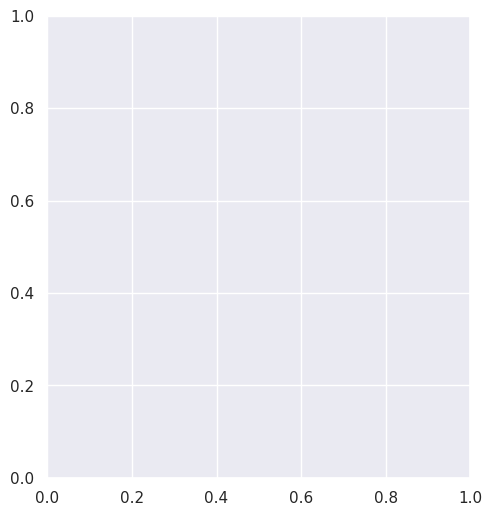

In [30]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
wordcloud(train_set_for_visual, iro = 0, is_subplot=True)
plt.subplot(1,2,2)
wordcloud(train_set_for_visual, iro = 1, is_subplot=True)

In [ ]:
from utils import show_mark_statistics

mark_list = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '...']
smileys = [':)', '=)', ':(', ':-)', ':-(', ':D', 'D:', ';)', ';(', ';-)', 'D-:', ':-D', ':))', ':((', '-.-', 'u.u', 'U.U', ':\')', 'c:', ' :c']
mark_list.extend(smileys)

show_mark_statistics(train_set_for_visual, mark_list)

,0,1
!,15.44,18.89
"""",5.21,3.23
#,37.71,40.55
$,0.02,0.00
%,0.96,0.35
&,0.28,0.12
',24.59,31.22
(,5.00,5.53
),7.44,8.99
*,1.51,1.15
